## CS6140 Final project 
### Can Tree-Based Models Always Outperform Neural Networks on Tabular Data?
#### Author: Yuxuan Wang and Pranav Sirnapalli

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.datasets import fetch_california_housing
from sklearn.compose import ColumnTransformer

from random_forest_classifier import RandomForestBinaryClassifier
from random_forest_regessor import RandomForestRegressor
from mlp_model import MLPTrainer
from xgboost_model import train_xgboost_classifier, train_xgboost_regressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Loading and Preprocessing 

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

adult_data = pd.read_csv(url, names=columns, skipinitialspace=True)
adult_data = adult_data.replace('?', np.nan).dropna()

adult_X = adult_data.drop('income', axis=1)
adult_y = (adult_data['income'] == '>50K').astype(int)

print(f" Adult data: {adult_X.shape}, positive label rate: {adult_y.mean():.3f}")

 Adult data: (30162, 14), positive label rate: 0.249


#### Adult_Income_data

In [3]:
categorical_cols = adult_X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = adult_X.select_dtypes(include=[np.number]).columns.tolist()

# Random Forest data（encode label)
adult_X_rf = adult_X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    adult_X_rf[col] = le.fit_transform(adult_X_rf[col])

# MLP data processing（std + One-Hot）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)
adult_X_mlp = preprocessor.fit_transform(adult_X)

print(f" RF feature shape: {adult_X_rf.shape},  MLP feature shape: {adult_X_mlp.shape}")


adult_X_rf_train, adult_X_rf_test, adult_y_train, adult_y_test = train_test_split(
    adult_X_rf, adult_y, test_size=0.2, random_state=RANDOM_STATE, stratify=adult_y
)
adult_X_mlp_train, adult_X_mlp_test, _, _ = train_test_split(
    adult_X_mlp, adult_y, test_size=0.2, random_state=RANDOM_STATE, stratify=adult_y
)

 RF feature shape: (30162, 14),  MLP feature shape: (30162, 96)


#### California_housing_data

In [4]:
california = fetch_california_housing()
california_X = pd.DataFrame(california.data, columns=california.feature_names)
california_y = california.target

print(f"California data shape: {california_X.shape}, Target mean: ${california_y.mean():.2f}k")


california_X_rf = california_X.copy()

scaler = StandardScaler()
california_X_mlp = scaler.fit_transform(california_X)

california_X_rf_train, california_X_rf_test, california_y_train, california_y_test = train_test_split(
    california_X_rf, california_y, test_size=0.2, random_state=RANDOM_STATE
)
california_X_mlp_train, california_X_mlp_test, _, _ = train_test_split(
    california_X_mlp, california_y, test_size=0.2, random_state=RANDOM_STATE
)

California data shape: (20640, 8), Target mean: $2.07k


## Part 1: Classification – UCI Adult
- Tree: RandomForest / XGBoost
- MLP: PyTorch MLPClassifier
- Metric: Accuracy / AUC

### Random Forest Classifier Trainning

Using known best params: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}

 Random Forest Result:
  ACCURACY: 0.8606
  F1_SCORE: 0.6879
  AUC: 0.9147

 Cross Valid Result:
  AUC: 0.9158 ± 0.0051


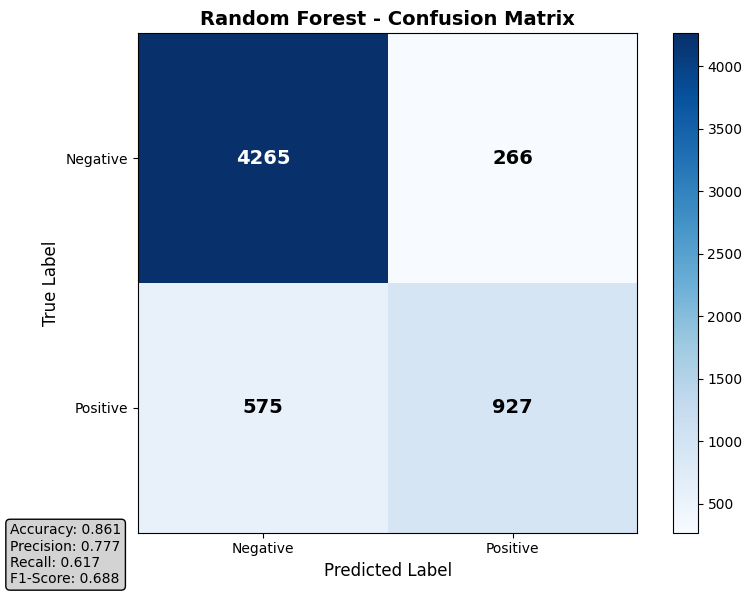

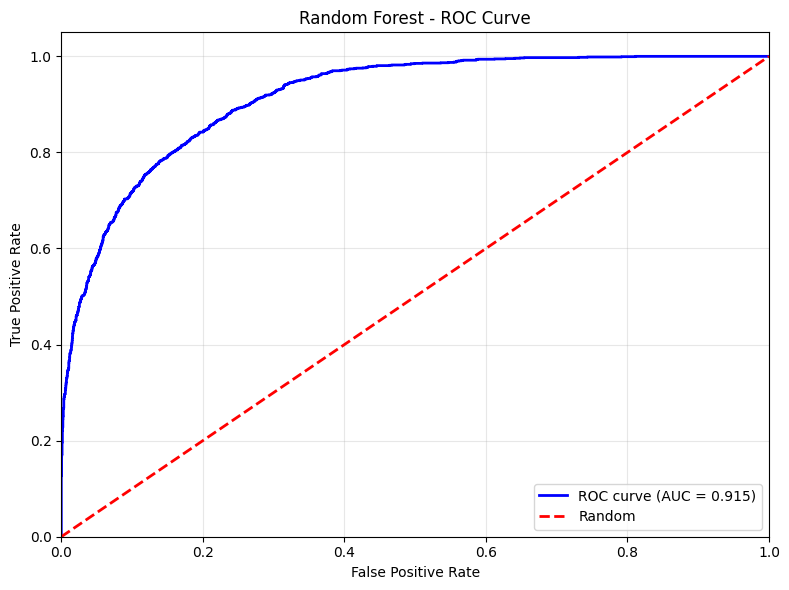

In [5]:

rf_classifier = RandomForestBinaryClassifier(random_state=RANDOM_STATE)

known_best_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt'
}

rf_classifier.best_params = known_best_params
print(f"Using known best params: {known_best_params}")

rf_classifier.train(adult_X_rf_train, adult_y_train, use_tuned_params=True)

rf_metrics = rf_classifier.evaluate(adult_X_rf_test, adult_y_test)
print("\n Random Forest Result:")
for metric, value in rf_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

cv_results = rf_classifier.cross_validate(adult_X_rf_train, adult_y_train)
print("\n Cross Valid Result:")
print(f"  AUC: {cv_results['auc_mean']:.4f} ± {cv_results['auc_std']:.4f}")


rf_classifier.plot_confusion_matrix(adult_X_rf_test, adult_y_test)
rf_classifier.plot_roc_curve(adult_X_rf_test, adult_y_test)

### MLP Classifier Trainning

Epoch [10/100], Train Loss: 0.3084, Val Loss: 0.3198
Early stopping at epoch 16


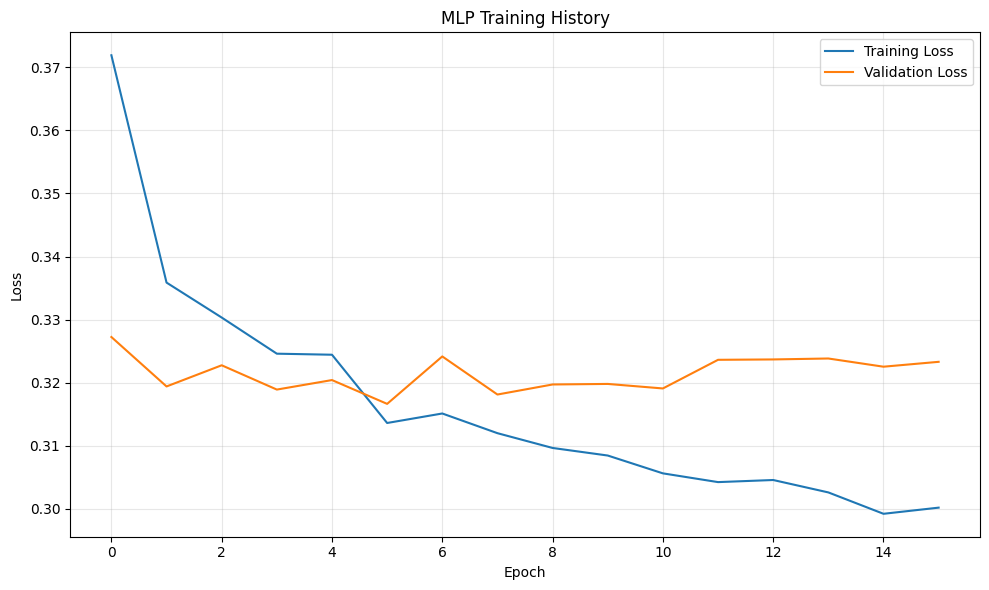


 MLP Classifier Results:
  ACCURACY: 0.8513
  F1_SCORE: 0.6627
  AUC: 0.9077


In [6]:
mlp_classifier = MLPTrainer(
    model_type='classifier',
    hidden_dims=[256, 128, 64],  # Hidden layer dimensions
    dropout_rate=0.3,            # Dropout rate
    learning_rate=0.001,
    batch_size=64,
    random_state=RANDOM_STATE
)

# Train the model
training_history = mlp_classifier.train(
    adult_X_mlp_train, adult_y_train.values,
    epochs=100,
    validation_split=0.2,          
    early_stopping_patience=10,    # Early stopping patience
    verbose=True                   
)

# Plot training and validation loss
mlp_classifier.plot_training_history()

# Evaluate the model on the test set
mlp_metrics = mlp_classifier.evaluate(adult_X_mlp_test, adult_y_test.values)
print("\n MLP Classifier Results:")
for metric, value in mlp_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")



### XGBoost Classifier Trainning

=== XGBoost Classification on UCI Adult Dataset ===
[Fold 1] XGBClassifier params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': 

<Figure size 800x600 with 0 Axes>

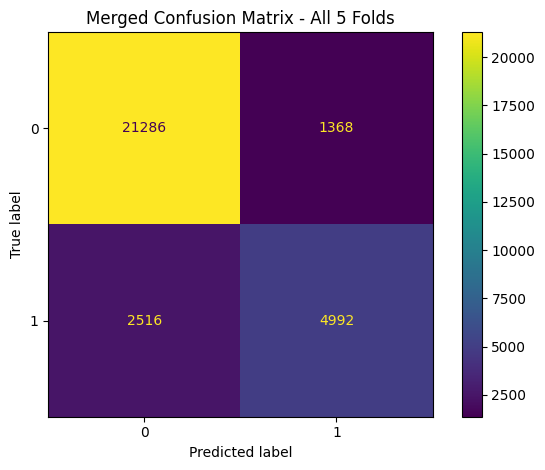

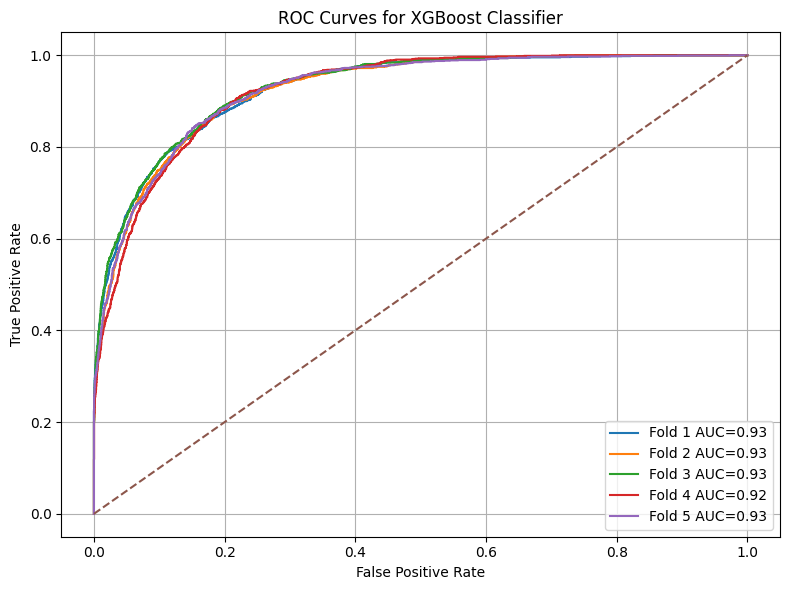

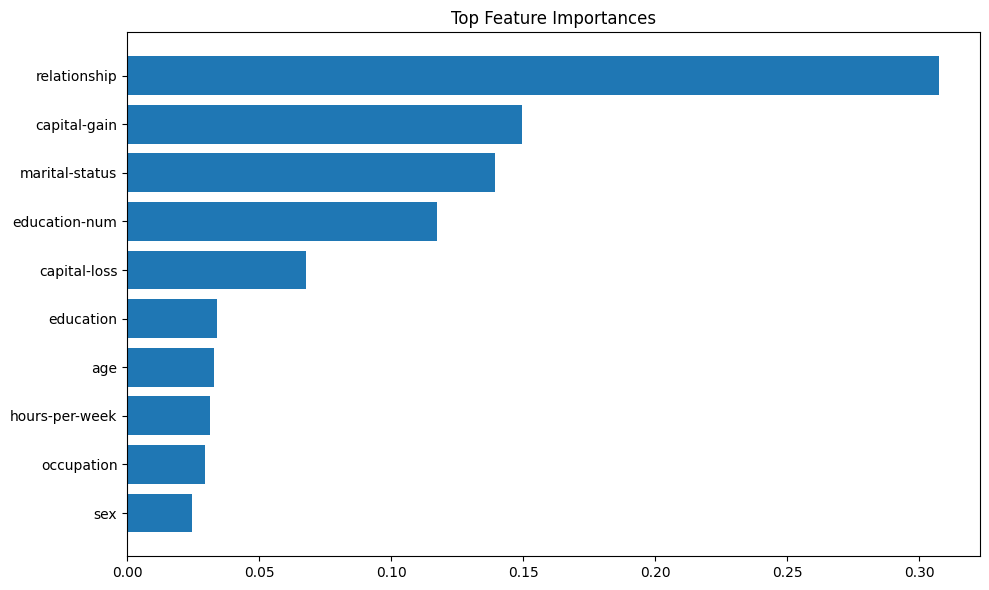

SHAP not available, skipping explanation plot.
Saved: xgboost_classifier_model.joblib


In [7]:
# Run XGBoost Classification
print("=== XGBoost Classification on UCI Adult Dataset ===")
adult_data['income'] = adult_data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
for col in adult_data.select_dtypes(include='object').columns.drop('income', errors='ignore'):
    adult_data[col] = LabelEncoder().fit_transform(adult_data[col])

X = adult_data.drop('income', axis=1).values
y = adult_data['income'].values
feature_names = adult_data.drop('income', axis=1).columns.tolist()
# xgb_clf = train_xgboost_classifier(X, y, feature_names=feature_names, n_splits=5, plot=True)
xgb_clf, xgb_clf_metrics = train_xgboost_classifier(X, y, feature_names=feature_names, n_splits=5, plot=True)

## Part 2: Regression – California Housing
- Tree: RandomForestRegressor / XGBoostRegressor
- MLP: PyTorch MLPRegressor
- Metric: RMSE / R²

### Random Forest Regressior Trainning

 Finding the best paramas...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

 Random Forest Regessior Result:
  RMSE: 0.4902
  R2: 0.8166
  MSE: 0.2403


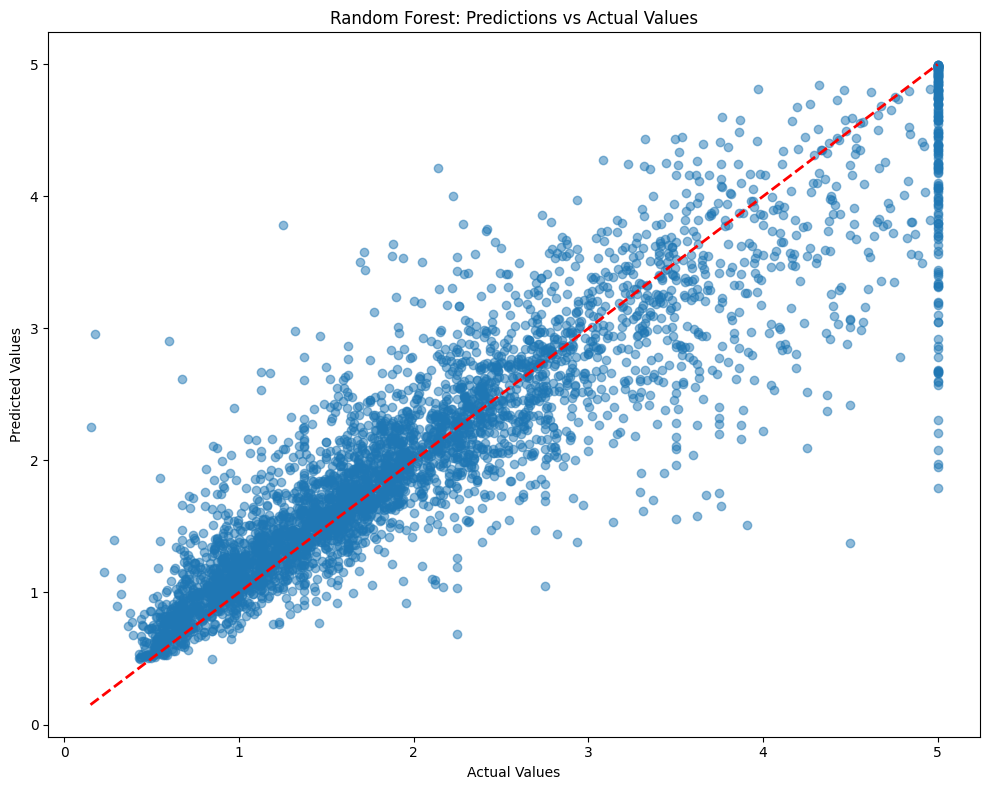

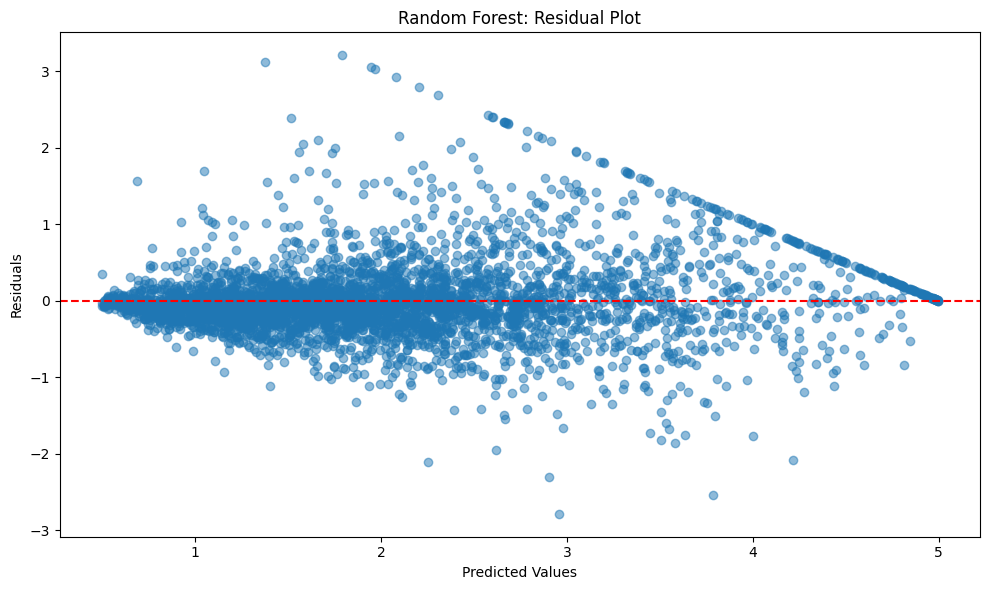

In [ ]:
rf_regressor = RandomForestRegressor(random_state=RANDOM_STATE)

# print(" Finding the best paramas...")
# best_params = rf_regressor.tune_hyperparameters(california_X_rf_train, california_y_train, cv_folds=3)
# print(f"Best Params: {best_params}")

known_best_params = {
    'n_estimators': 300,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2'
}

rf_classifier.best_params = known_best_params
print(f"Using known best params: {known_best_params}")

rf_regressor.train(california_X_rf_train, california_y_train, use_tuned_params=True)

rf_reg_metrics = rf_regressor.evaluate(california_X_rf_test, california_y_test)
print("\n Random Forest Regessior Result:")
for metric, value in rf_reg_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

rf_regressor.plot_predictions(california_X_rf_test, california_y_test)

### MLP Regressier Trainnning

Epoch [10/100], Train Loss: 0.4100, Val Loss: 0.9304
Early stopping at epoch 12


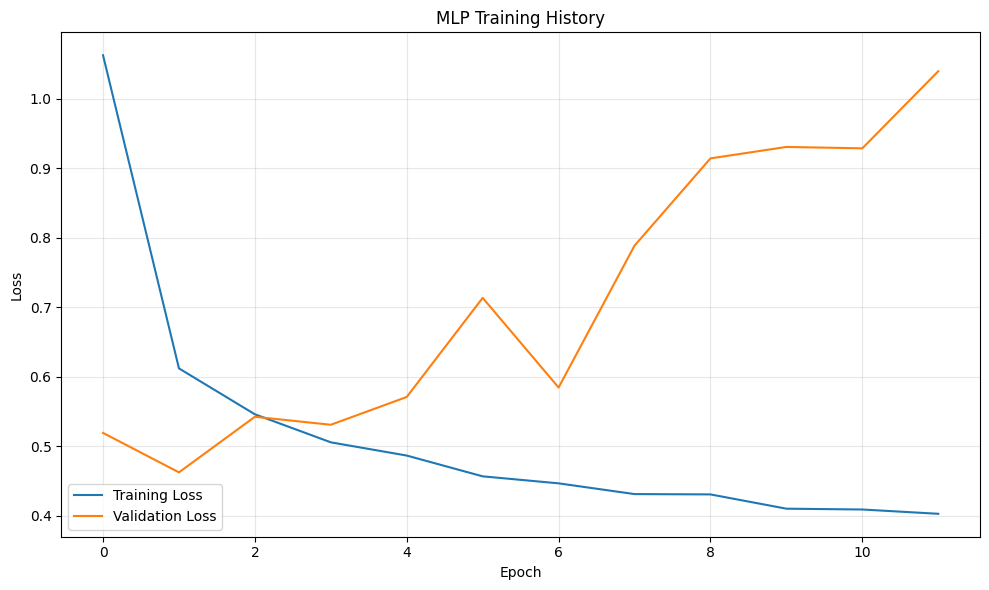


 MLP Regressior Result:
  RMSE: 0.5759
  R2: 0.7469
  MSE: 0.3317


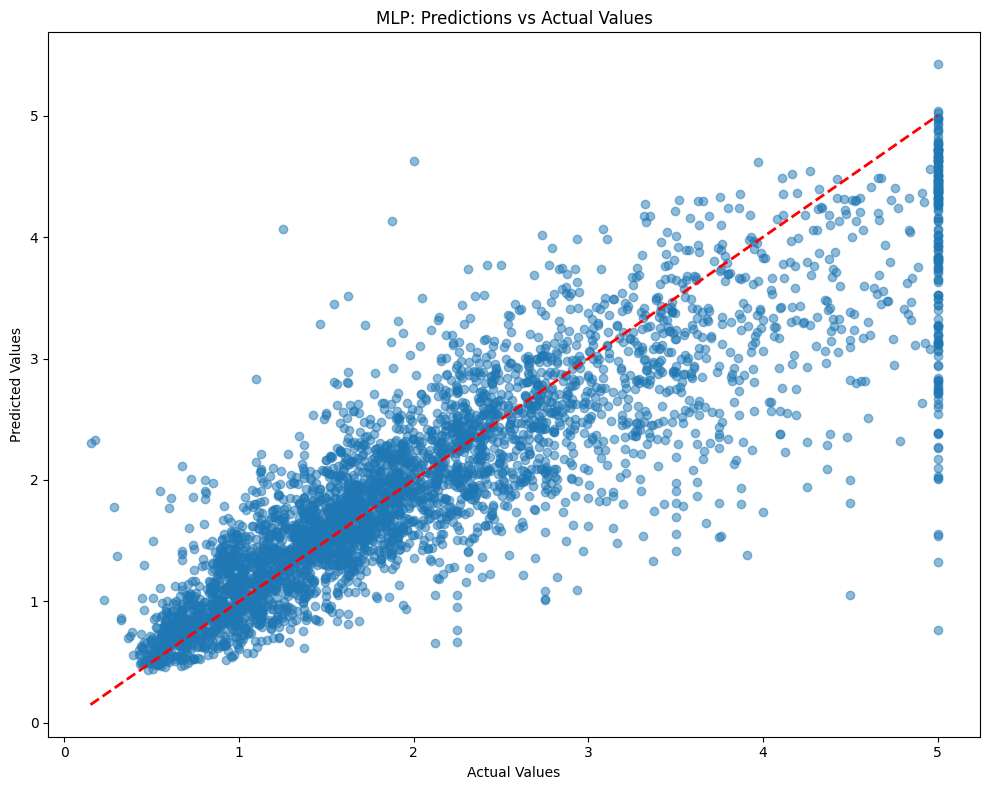

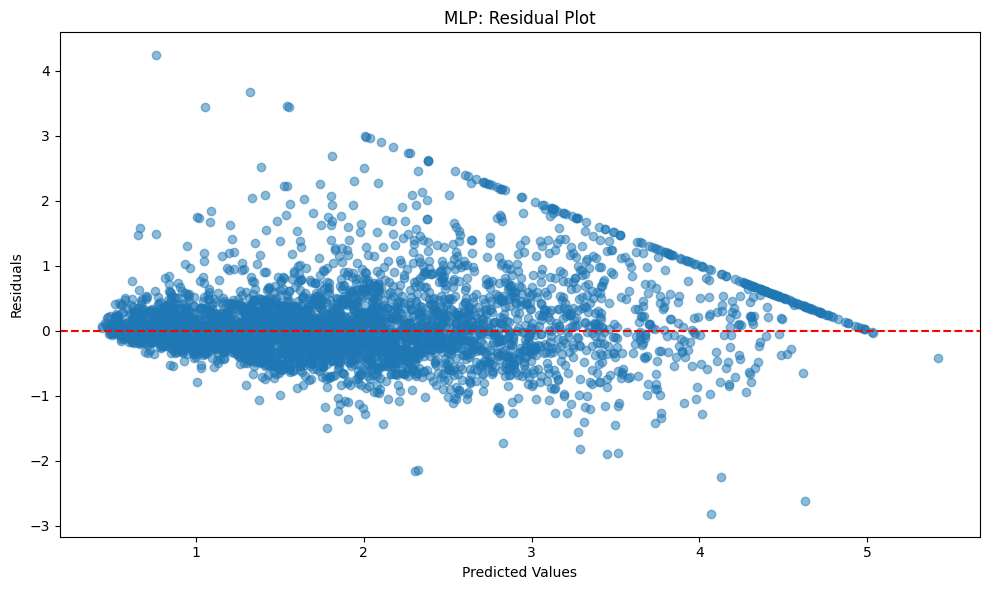

In [10]:
mlp_regressor = MLPTrainer(
    model_type='regressor',
    hidden_dims=[256, 128, 64],
    dropout_rate=0.3,
    learning_rate=0.001,
    batch_size=64,
    random_state=RANDOM_STATE
)


training_history = mlp_regressor.train(
    california_X_mlp_train, california_y_train,
    epochs=100,
    validation_split=0.2,
    early_stopping_patience=10,
    verbose=True
)

mlp_regressor.plot_training_history()

mlp_reg_metrics = mlp_regressor.evaluate(california_X_mlp_test, california_y_test)
print("\n MLP Regressior Result:")
for metric, value in mlp_reg_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

mlp_regressor.plot_predictions(california_X_mlp_test, california_y_test)

### XGBoost Regessior Trainning

=== XGBoost Regression on California Housing Dataset ===
[Fold 1] XGBRegressor params: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
[Fold 2] XGBRegressor

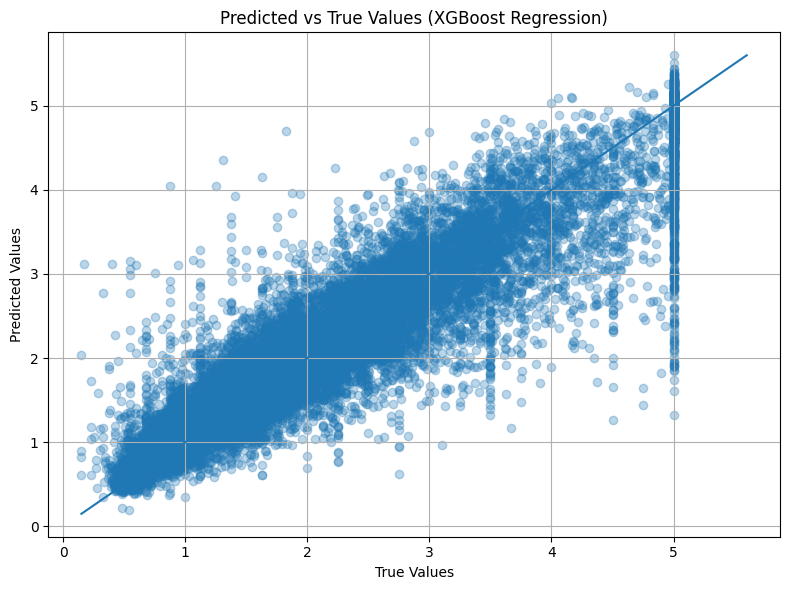

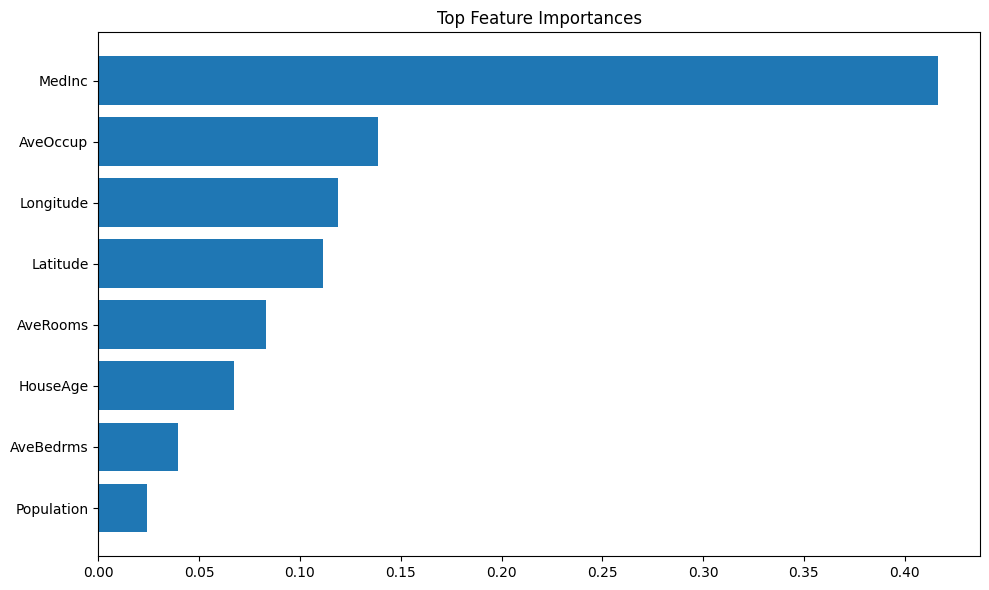

Saved: xgboost_regressor_model.joblib


In [11]:
# Run XGBoost Regression
print("=== XGBoost Regression on California Housing Dataset ===")
feature_names = california.feature_names
# xgb_reg = train_xgboost_regressor(california_X_mlp, california_y, feature_names=feature_names, n_splits=5, plot=True)
xgb_reg, xgb_reg_metrics = train_xgboost_regressor(california_X_mlp, california_y, feature_names=feature_names, n_splits=5, plot=True)


## Summary


In [ ]:
def create_comprehensive_results_summary():
    """
    Create a comprehensive results summary table for all models
    """
    
    # Classification Results (UCI Adult Dataset)
    classification_results = {
        'Model': ['Random Forest', 'XGBoost', 'MLP'],
        'Accuracy': [
            rf_metrics['accuracy'],
            xgb_clf_metrics['accuracy'],  
            mlp_metrics['accuracy']
        ],
        'AUC': [
            rf_metrics['auc'],
            xgb_clf_metrics['auc'], 
            mlp_metrics['auc']
        ],
        'F1-Score': [
            rf_metrics['f1_score'],
            xgb_clf_metrics['f1_score'],  
            mlp_metrics['f1_score']
        ]
    }
    
    # Regression Results (California Housing Dataset)
    regression_results = {
        'Model': ['Random Forest', 'XGBoost', 'MLP'],
        'RMSE': [
            rf_reg_metrics['rmse'],
            xgb_reg_metrics['rmse'],  
            mlp_reg_metrics['rmse']
        ],
        'R²': [
            rf_reg_metrics['r2'],
            xgb_reg_metrics['r2'],  
            mlp_reg_metrics['r2']
        ],
        'MSE': [
            rf_reg_metrics['mse'],
            xgb_reg_metrics['mse'],  
            mlp_reg_metrics['mse']
        ]
    }
    
    # Create DataFrames
    classification_df = pd.DataFrame(classification_results)
    regression_df = pd.DataFrame(regression_results)
    
    # Display results
    print("="*70)
    print("FINAL RESULTS SUMMARY - Tree vs Neural Network Performance")
    print("="*70)
    
    print("\nCLASSIFICATION RESULTS (UCI Adult Dataset)")
    print("-" * 60)
    print(classification_df.round(4).to_string(index=False))
    
    print("\nREGRESSION RESULTS (California Housing Dataset)")
    print("-" * 55)
    print(regression_df.round(4).to_string(index=False))
    
    print("\n BEST PERFORMING MODELS")
    print("-" * 35)

    best_acc_idx = classification_df['Accuracy'].idxmax()
    best_auc_idx = classification_df['AUC'].idxmax()
    best_f1_idx = classification_df['F1-Score'].idxmax()
    
    print("Classification:")
    print(f"  • Best Accuracy: {classification_df.loc[best_acc_idx, 'Model']} ({classification_df.loc[best_acc_idx, 'Accuracy']:.4f})")
    print(f"  • Best AUC: {classification_df.loc[best_auc_idx, 'Model']} ({classification_df.loc[best_auc_idx, 'AUC']:.4f})")
    print(f"  • Best F1-Score: {classification_df.loc[best_f1_idx, 'Model']} ({classification_df.loc[best_f1_idx, 'F1-Score']:.4f})")
    
    best_rmse_idx = regression_df['RMSE'].idxmin()  # Lower is better for RMSE
    best_r2_idx = regression_df['R²'].idxmax()     # Higher is better for R²
    
    print("\nRegression:")
    print(f"  • Best RMSE: {regression_df.loc[best_rmse_idx, 'Model']} ({regression_df.loc[best_rmse_idx, 'RMSE']:.4f})")
    print(f"  • Best R²: {regression_df.loc[best_r2_idx, 'Model']} ({regression_df.loc[best_r2_idx, 'R²']:.4f})")
    
    
    return classification_df, regression_df
create_comprehensive_results_summary()

FINAL RESULTS SUMMARY - Tree vs Neural Network Performance

CLASSIFICATION RESULTS (UCI Adult Dataset)
------------------------------------------------------------
        Model  Accuracy    AUC  F1-Score
Random Forest    0.8606 0.9147    0.6879
      XGBoost    0.8712 0.9265    0.7199
          MLP    0.8513 0.9077    0.6627

REGRESSION RESULTS (California Housing Dataset)
-------------------------------------------------------
        Model   RMSE     R²    MSE
Random Forest 0.4902 0.8166 0.2403
      XGBoost 0.4550 0.8443 0.2071
          MLP 0.5759 0.7469 0.3317

 BEST PERFORMING MODELS
-----------------------------------
Classification:
  • Best Accuracy: XGBoost (0.8712)
  • Best AUC: XGBoost (0.9265)
  • Best F1-Score: XGBoost (0.7199)

Regression:
  • Best RMSE: XGBoost (0.4550)
  • Best R²: XGBoost (0.8443)

 PERFORMANCE ANALYSIS
-------------------------


(           Model  Accuracy       AUC  F1-Score
 0  Random Forest  0.860600  0.914719  0.687941
 1        XGBoost  0.871229  0.926518  0.719854
 2            MLP  0.851318  0.907731  0.662655,
            Model      RMSE        R²       MSE
 0  Random Forest  0.490223  0.816608  0.240318
 1        XGBoost  0.454992  0.844342  0.207118
 2            MLP  0.575945  0.746863  0.331713)